In [2]:
from astropy.io import fits

In [19]:
import astropy.units as u
import astropy.constants
from astropy.coordinates import SkyCoord

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
from astropy.visualization import quantity_support
quantity_support();

In [7]:
%matplotlib inline

Data from http://vizier.cfa.harvard.edu/viz-bin/VizieR-2?-source=+VIII%2F76%2Fbvmaps&-from=nav&-nav=cat%3AVIII%2F76%26tab%3A%7BVIII%2F76%2Fbvmaps%7D%26key%3Asource%3DVIII%2F76%26HTTPPRM%3A%26

In [8]:
fitsdata = fits.open("labh.fit")[0]

In [9]:
v0 = fitsdata.header.cards['CRVAL3'][1]*u.m/u.s

In [10]:
v0

<Quantity -458604.5262155 m / s>

In [11]:
vincr = fitsdata.header.cards['CDELT3'][1]*u.m/u.s

In [12]:
data = fitsdata.data

In [13]:
data.shape

(891, 361, 721)

In [14]:
def frame_to_v(frame_nr):
    return v0 + frame_nr*vincr

In [15]:
((0*u.m/u.s - v0)/vincr).value # Frame with rest frequency

445.0000000101885

In [16]:
def v_to_frame(v):
    return round(((v*u.m/u.s - v0)/vincr).value)

In [17]:
def lb_to_xy(l, b):
    """Convert galactic longitude, latitude to pixel coordinates
    
    Args:
        (l, b) (Tuple[int, int]): latitude and longitude in degrees
        
    Returns:
        Tuple[int, int]: x and y coordinates, x from 0 to 720, y from 0 to 360
    """
    return (2*((180-l0)%360), 2*(b0+90))

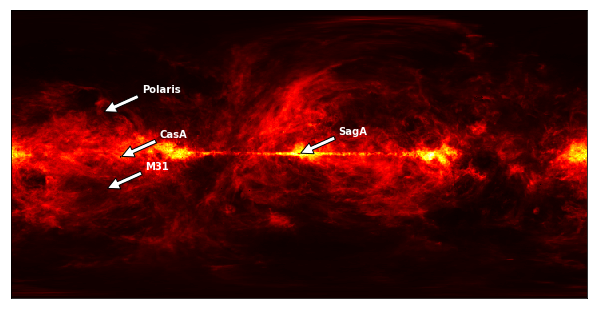

In [25]:
fig, ax = plt.subplots(figsize=(8, 16/data.shape[2]*data.shape[1]))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(data[v_to_frame(0),:,:], cmap='hot', vmin=0, vmax=151, origin='lower')
objs = ["SagA", "CasA", "Polaris", "M31"]
for obj in objs:
    m31 = SkyCoord.from_name(obj)
    m31_gal = m31.galactic
    l0 = round(m31_gal.l.to(u.deg).value)
    b0 = round(m31_gal.b.to(u.deg).value)
    ax.annotate(obj, xy=lb_to_xy(l0+2,b0+2),
                xytext=(40, 20), textcoords='offset points',
                arrowprops=dict(facecolor='white', shrink=0.05), color='white',
                weight='bold'
                );

In [73]:
data.shape

(891, 361, 721)

In [26]:
velocities = np.arange(v0.value, v0.value+891*vincr.value, vincr.value) * v0.unit

In [27]:
from astropy.coordinates import SkyCoord

In [28]:
m31 = SkyCoord.from_name("M31")

In [29]:
data.shape

(891, 361, 721)

In [30]:
def get_line_data(skycoord):
    gal_coord = skycoord.galactic
    l = round(gal_coord.l.to(u.deg).value)
    b = round(gal_coord.b.to(u.deg).value)
    return data[:, 180+b, 2*l]

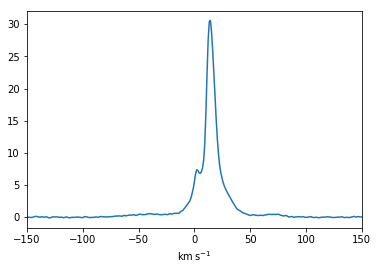

In [31]:
plt.plot(velocities.to(u.km/u.s), get_line_data(m31));
plt.xlim([-150,150]);

In [32]:
m31 = SkyCoord.from_name("M31")
m31_gal = m31.galactic
l0 = round(m31_gal.l.to(u.deg).value)
b0 = round(m31_gal.b.to(u.deg).value)

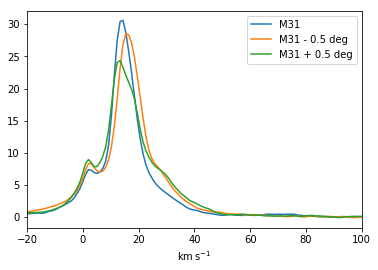

In [33]:
ref = data[:, 180+b0, 2*(l0-3)]
plt.plot(velocities.to(u.km/u.s), data[:, 180+b0, 2*l0], label="M31");
plt.plot(velocities.to(u.km/u.s), data[:, 180+b0, 2*(l0-1)], label="M31 - 0.5 deg");
plt.plot(velocities.to(u.km/u.s), data[:, 180+b0, 2*(l0+1)], label="M31 + 0.5 deg");
plt.xlim([-20,100]);
#plt.ylim([0,4]);
plt.legend();

In [34]:
def vlsr_to_freq(vlsr):
    """Convert speed to frequency"""
    freq_hi = 1420.405751 * u.MHz
    # TODO: should the plus be a minus?
    return freq_hi * (1 + vlsr/astropy.constants.c)

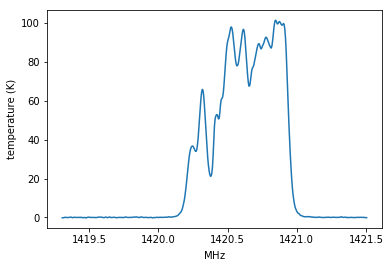

In [35]:
fig, ax = plt.subplots()
ax.plot(vlsr_to_freq(velocities.to(u.km/u.s)[220:-220]), data[220:-220, 180, 300]);
#ax.set_ylim(0,151);
ax.set_ylabel("temperature (K)");